In [ ]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

import os
# change working directory
os.chdir('/Users/gerardogutierrez/Desktop/Academics/Spring_2026/plant-health-status')

pd.set_option('display.max_columns', None)  # Show all columns in DataFrame display

## Helper Functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

def plot_factor_with_actuators(
    df,
    factor_col,
    actuator_cols,
    datetime_col="DateTime",
    title=None,
    start=None,
    end=None,
    figsize=(14, 6),
    factor_linewidth=1.8,
    factor_alpha=0.95,
    marker="*",
    markersize=6,
    marker_color="black",
    factor_time_col=None,     # <-- pass "EnvTime" here to get TRUE factor timestamps
):
    """
    Single-dataframe plot with correct factor timing.

    - Actuator timing uses df[datetime_col] (event/log timeline).
    - Factor timing uses df[factor_time_col] if provided (TRUE sensor measurement timestamps).
      If factor_time_col is None, it falls back to datetime_col.

    This fixes the "factor changes late" problem when merged df has factor values copied onto actuator timestamps.
    """

    # --- Checks ---
    if datetime_col not in df.columns:
        raise ValueError(f"'{datetime_col}' not found in df.")
    if factor_col not in df.columns:
        raise ValueError(f"'{factor_col}' not found in df.")
    missing = [c for c in actuator_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing actuator columns in df: {missing}")

    ftc = factor_time_col or datetime_col
    if ftc not in df.columns:
        raise ValueError(
            f"factor_time_col='{ftc}' not found in df. "
            f"Pass factor_time_col=None to use '{datetime_col}', or ensure '{ftc}' exists (e.g. 'EnvTime')."
        )

    # --- Prepare dataframe ---
    d = df.copy()
    d[datetime_col] = pd.to_datetime(d[datetime_col], errors="coerce")
    d[ftc] = pd.to_datetime(d[ftc], errors="coerce")
    d = d.dropna(subset=[datetime_col]).sort_values(datetime_col).reset_index(drop=True)

    # window bounds (defined on actuator/event time axis)
    t_start = pd.to_datetime(start) if start is not None else d[datetime_col].min()
    t_end   = pd.to_datetime(end)   if end is not None else d[datetime_col].max()

    # filter for actuator plotting (event axis)
    d_win = d[(d[datetime_col] >= t_start) & (d[datetime_col] <= t_end)].copy()
    if d_win.empty:
        raise ValueError("No data after filtering to the requested time window.")

    # --- Build factor step series using TRUE measurement times (ftc) ---
    env_all = d[[ftc, factor_col]].dropna(subset=[ftc, factor_col]).sort_values(ftc)
    if env_all.empty:
        raise ValueError(f"No non-null values found for factor_col='{factor_col}' using time col '{ftc}'.")

    # anchor at window start: last known measurement at/before t_start
    pre_row = env_all[env_all[ftc] <= t_start].tail(1)
    env_in_window = env_all[(env_all[ftc] >= t_start) & (env_all[ftc] <= t_end)].copy()

    plot_env_parts = []
    if not pre_row.empty:
        plot_env_parts.append(pd.DataFrame({ftc: [t_start], factor_col: [pre_row.iloc[0][factor_col]]}))
    if not env_in_window.empty:
        plot_env_parts.append(env_in_window)

    if not plot_env_parts:
        raise ValueError("No factor measurements in/around the window to anchor the step plot.")

    plot_env = pd.concat(plot_env_parts, ignore_index=True).sort_values(ftc)

    # extend to window end so the last value holds through t_end
    plot_env = pd.concat(
        [plot_env, pd.DataFrame({ftc: [t_end], factor_col: [plot_env.iloc[-1][factor_col]]})],
        ignore_index=True
    ).sort_values(ftc)

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=figsize)

    # Factor (blue): plotted on TRUE timestamps (ftc)
    ax.step(
        plot_env[ftc],
        plot_env[factor_col],
        where="post",
        color="tab:blue",
        linewidth=factor_linewidth,
        alpha=factor_alpha,
        label=factor_col,
        zorder=3,
    )
    ax.set_ylabel(factor_col)
    ax.set_xlabel(datetime_col)

    # datetime formatting
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # --- Actuators (exact ON segments) on right axis using datetime_col ---
    ax2 = ax.twinx()
    lane_gap = 1.2
    lane_y = {act: i * lane_gap for i, act in enumerate(actuator_cols)}
    ax2.set_yticks([lane_y[a] + 0.5 for a in actuator_cols])
    ax2.set_yticklabels([a.replace(" Duration", "") for a in actuator_cols])
    ax2.set_ylim(-0.2, lane_gap * len(actuator_cols) - lane_gap + 1.2)
    ax2.set_ylabel("Actuators ON/OFF (lanes)")

    palette5 = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    colors = {c: palette5[i % len(palette5)] for i, c in enumerate(actuator_cols)}

    for act in actuator_cols:
        ev = d_win[[datetime_col, act]].copy()
        ev[act] = pd.to_numeric(ev[act], errors="coerce").fillna(0.0)
        ev = ev[ev[act] > 0].sort_values(datetime_col)

        lane = lane_y[act]
        color = colors[act]

        # ON segments: [start, start+duration]
        for _, row in ev.iterrows():
            s = row[datetime_col]
            e = s + pd.to_timedelta(row[act], unit="s")

            if e < t_start or s > t_end:
                continue
            s = max(s, t_start)
            e = min(e, t_end)

            ax2.step(
                [s, e],
                [lane + 1, lane + 1],
                where="post",
                color=color,
                linewidth=1.6,
                alpha=0.9,
                label=act.replace(" Duration", ""),
                zorder=2,
            )

        # markers at ON start times
        if not ev.empty:
            starts_dt = ev[datetime_col]
            ax2.plot(
                starts_dt,
                np.full(len(starts_dt), lane + 1),
                marker=marker,
                linestyle="None",
                color=marker_color,
                markersize=markersize,
                zorder=4,
            )

        # lane divider
        ax2.hlines(
            lane + 0.5,
            t_start,
            t_end,
            colors="lightgray",
            linewidth=0.5,
            alpha=0.6,
        )

    # Title
    if title is None:
        title = f"{factor_col} + Actuator Activations (right axis)"
    ax.set_title(title)

    # Legend: factor + actuator patches (prevents duplicate labels from many step segments)
    patches = [mpatches.Patch(color=colors[c], label=c.replace(" Duration", "")) for c in actuator_cols]
    handles = [ax.lines[0]] + patches
    ax.legend(handles=handles, loc="upper left", fontsize=9)

    fig.tight_layout()
    plt.show()
    return fig, (ax, ax2)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# scatter
def plot_factor_with_actuators_scatter(
    df,
    factor_col,
    actuator_cols,
    datetime_col="DateTime",
    title=None,
    start=None,
    end=None,
    figsize=(14, 6),
    factor_linewidth=1.8,     # kept for compatibility (not used for scatter)
    factor_alpha=0.95,
    marker="*",
    markersize=6,
    marker_color="black",
    factor_time_col=None,     # <-- pass "EnvTime" / "NutrTime" for TRUE factor timestamps
):
    """
    Single-dataframe plot with correct factor timing.

    - Actuator timing uses df[datetime_col] (event/log timeline).
    - Factor timing uses df[factor_time_col] if provided (TRUE sensor measurement timestamps).
      If factor_time_col is None, it falls back to datetime_col.

    Factor is plotted as SCATTER (blue points) at true measurement timestamps.
    Actuators are plotted as exact ON segments + optional markers at ON start.
    """

    # --- Checks ---
    if datetime_col not in df.columns:
        raise ValueError(f"'{datetime_col}' not found in df.")
    if factor_col not in df.columns:
        raise ValueError(f"'{factor_col}' not found in df.")
    missing = [c for c in actuator_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing actuator columns in df: {missing}")

    ftc = factor_time_col or datetime_col
    if ftc not in df.columns:
        raise ValueError(
            f"factor_time_col='{ftc}' not found in df. "
            f"Pass factor_time_col=None to use '{datetime_col}', or ensure '{ftc}' exists (e.g. 'EnvTime')."
        )

    # --- Prepare dataframe ---
    d = df.copy()
    d[datetime_col] = pd.to_datetime(d[datetime_col], errors="coerce")
    d[ftc] = pd.to_datetime(d[ftc], errors="coerce")
    d = d.dropna(subset=[datetime_col]).sort_values(datetime_col).reset_index(drop=True)

    # window bounds (defined on actuator/event time axis)
    t_start = pd.to_datetime(start) if start is not None else d[datetime_col].min()
    t_end   = pd.to_datetime(end)   if end is not None else d[datetime_col].max()

    # filter for actuator plotting (event axis)
    d_win = d[(d[datetime_col] >= t_start) & (d[datetime_col] <= t_end)].copy()
    if d_win.empty:
        raise ValueError("No data after filtering to the requested time window.")

    # --- Factor points using TRUE measurement times (ftc) ---
    env_all = d[[ftc, factor_col]].dropna(subset=[ftc, factor_col]).sort_values(ftc)
    if env_all.empty:
        raise ValueError(f"No non-null values found for factor_col='{factor_col}' using time col '{ftc}'.")

    # only plot points in the window
    plot_env = env_all[(env_all[ftc] >= t_start) & (env_all[ftc] <= t_end)].copy()
    if plot_env.empty:
        raise ValueError("No factor measurements inside the requested window.")

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=figsize)

    # Factor as scatter (blue points) at TRUE timestamps
    factor_handle = ax.scatter(
        plot_env[ftc],
        plot_env[factor_col],
        color="tab:blue",
        alpha=factor_alpha,
        s=22,                 # point size (change this if you want bigger)
        label=factor_col,
        zorder=3,
    )
    ax.set_ylabel(factor_col)
    ax.set_xlabel(datetime_col)

    # datetime formatting
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # --- Actuators on right axis using datetime_col ---
    ax2 = ax.twinx()
    lane_gap = 1.2
    lane_y = {act: i * lane_gap for i, act in enumerate(actuator_cols)}
    ax2.set_yticks([lane_y[a] + 0.5 for a in actuator_cols])
    ax2.set_yticklabels([a.replace(" Duration", "") for a in actuator_cols])
    ax2.set_ylim(-0.2, lane_gap * len(actuator_cols) - lane_gap + 1.2)
    ax2.set_ylabel("Actuators ON/OFF (lanes)")

    palette5 = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    colors = {c: palette5[i % len(palette5)] for i, c in enumerate(actuator_cols)}

    for act in actuator_cols:
        ev = d_win[[datetime_col, act]].copy()
        ev[act] = pd.to_numeric(ev[act], errors="coerce").fillna(0.0)
        ev = ev[ev[act] > 0].sort_values(datetime_col)

        lane = lane_y[act]
        color = colors[act]

        # ON segments: [start, start+duration]
        for _, row in ev.iterrows():
            s = row[datetime_col]
            e = s + pd.to_timedelta(row[act], unit="s")

            if e < t_start or s > t_end:
                continue
            s = max(s, t_start)
            e = min(e, t_end)

            ax2.step(
                [s, e],
                [lane + 1, lane + 1],
                where="post",
                color=color,
                linewidth=1.6,
                alpha=0.9,
                label=act.replace(" Duration", ""),
                zorder=2,
            )

        # markers at ON start times
        if not ev.empty:
            starts_dt = ev[datetime_col]
            ax2.plot(
                starts_dt,
                np.full(len(starts_dt), lane + 1),
                marker=marker,
                linestyle="None",
                color=marker_color,
                markersize=markersize,
                zorder=4,
            )

        # lane divider
        ax2.hlines(
            lane + 0.5,
            t_start,
            t_end,
            colors="lightgray",
            linewidth=0.5,
            alpha=0.6,
        )

    # Title
    if title is None:
        title = f"{factor_col} + Actuator Activations (right axis)"
    ax.set_title(title)

    # Legend: factor + actuator patches
    patches = [mpatches.Patch(color=colors[c], label=c.replace(" Duration", "")) for c in actuator_cols]
    handles = [factor_handle] + patches
    ax.legend(handles=handles, loc="upper left", fontsize=9)

    fig.tight_layout()
    plt.show()
    return fig, (ax, ax2)

# Environmental

In [6]:
merged_env_df = pd.read_csv('../Data/merged_env_df.csv')
merged_nutrient_df = pd.read_csv('../Data/merged_nutr_df.csv')

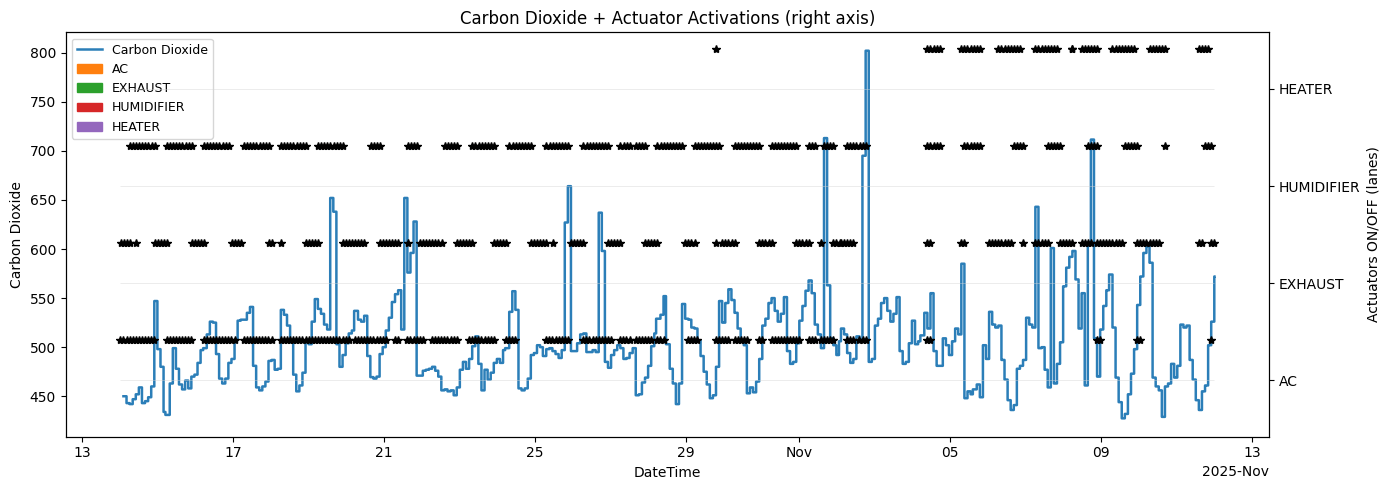

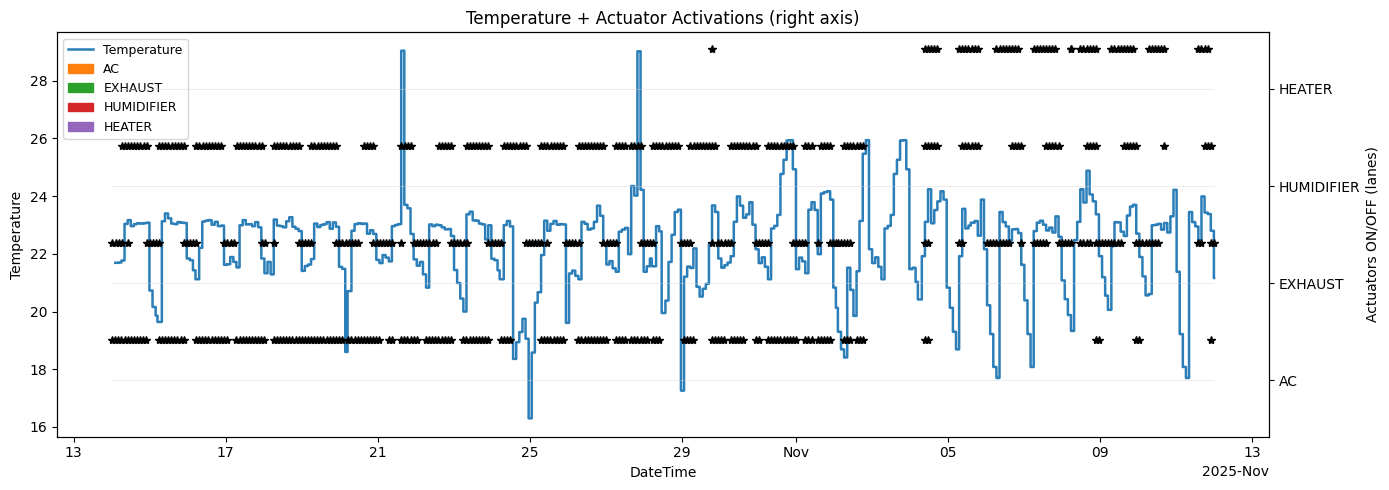

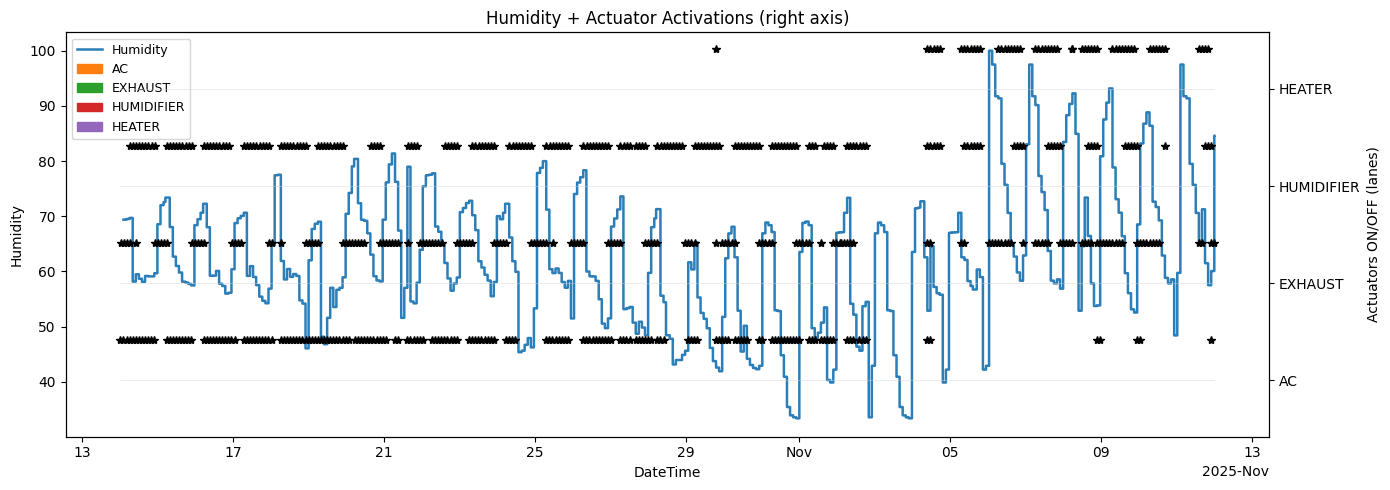

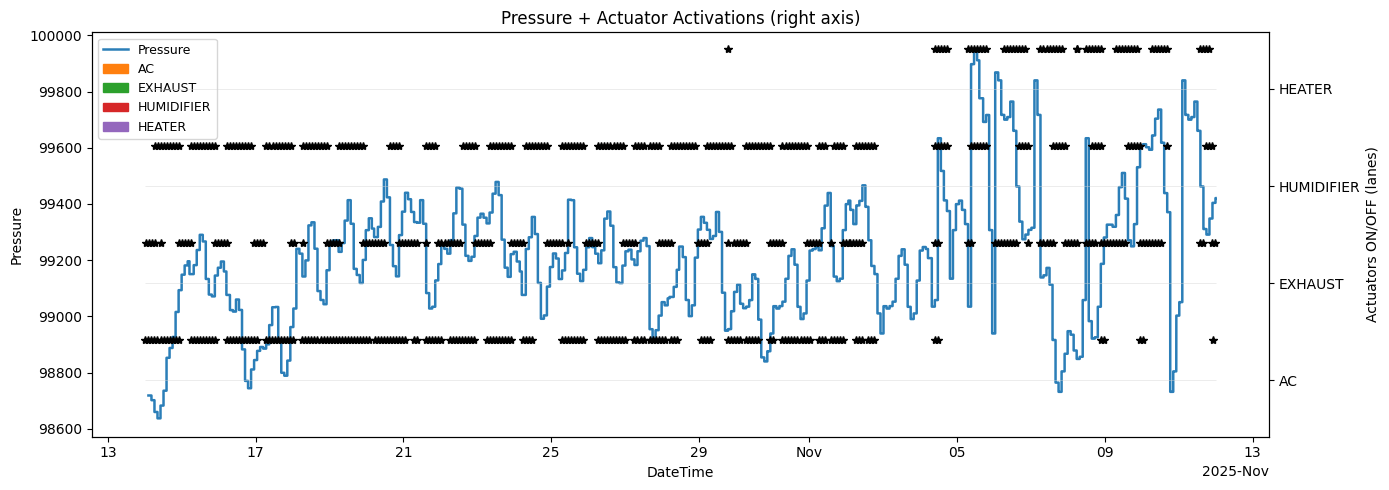

In [7]:
#  Loop over all environmental cols and plot with actuators
env_cols = ["Carbon Dioxide", "Temperature", "Humidity", "Pressure"]
act_cols = ["AC Duration", "EXHAUST Duration", "HUMIDIFIER Duration", "HEATER Duration"]

#
for env in env_cols:
    plot_factor_with_actuators(
        df=merged_env_df,
        factor_col=env,
        actuator_cols=act_cols,
        start=None,
        end=None,        
        figsize=(14,5)
    )


In [13]:
merged_env_df

,DateTime,LIGHT Duration,AC Duration,EXHAUST Duration,HUMIDIFIER Duration,HEATER Duration,EnvTime,Carbon Dioxide,Temperature,Humidity,Pressure,Day
0,2025-10-14 00:21:44,0.0,360.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-14 00:35:37,0.0,0.000,60.035,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-10-14 01:11:24,0.0,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-10-14 02:19:28,0.0,360.000,0.000,0.000,0.0,2025-10-14 01:25:06,450.0,21.69,69.39,98718.64,0.0
4,2025-10-14 02:33:18,0.0,0.000,60.027,0.000,0.0,2025-10-14 01:25:06,450.0,21.69,69.39,98718.64,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1093,2025-11-11 21:55:31,0.0,0.000,59.992,59.993,0.0,2025-11-11 21:16:44,526.0,22.80,60.08,99404.03,28.0
1094,2025-11-11 21:59:20,0.0,60.039,0.000,0.000,0.0,2025-11-11 21:16:44,526.0,22.80,60.08,99404.03,28.0
1095,2025-11-11 22:37:12,0.0,0.000,0.000,0.000,0.0,2025-11-11 21:16:44,526.0,22.80,60.08,99404.03,28.0
1096,2025-11-11 23:53:12,0.0,0.000,59.985,0.000,0.0,2025-11-11 23:14:30,572.0,21.16,84.60,99421.01,28.0


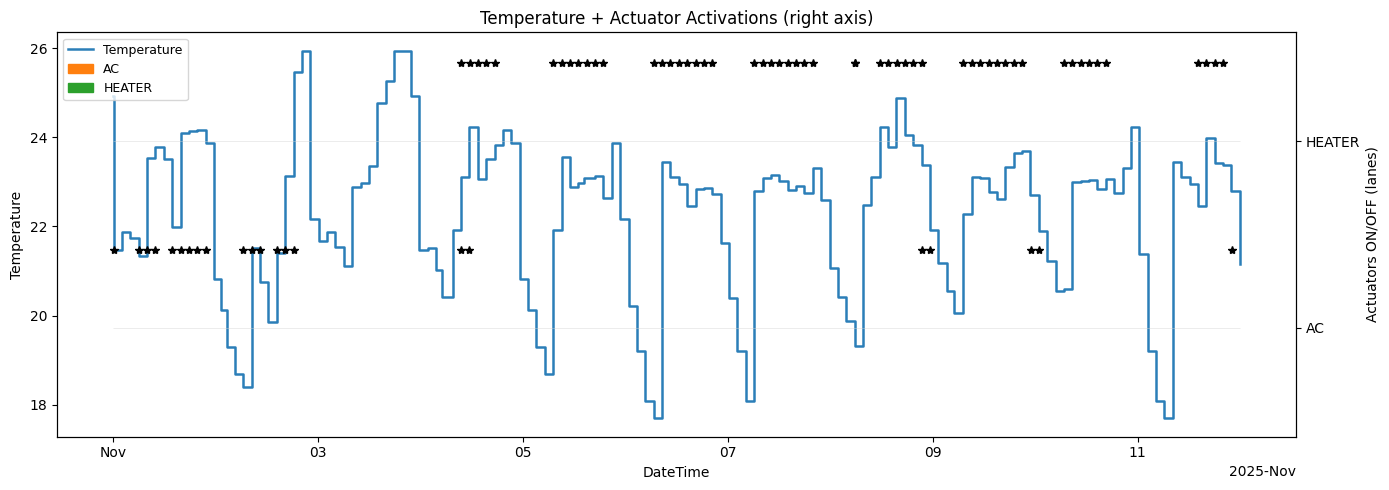

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': 'Temperature + Actuator Activations (right axis)'}, xlabel='DateTime', ylabel='Temperature'>,
  <Axes: ylabel='Actuators ON/OFF (lanes)'>))

In [17]:
plot_factor_with_actuators(
        df=merged_env_df,
        factor_col='Temperature',
        actuator_cols=['AC Duration', 'HEATER Duration'],
        start='11-01-2025 00:00:00',
        end=None,        
        figsize=(14,5)
    )

# Nutrients

In [9]:
merged_nutr_df = pd.read_csv('../Data/merged_nutr_df.csv')

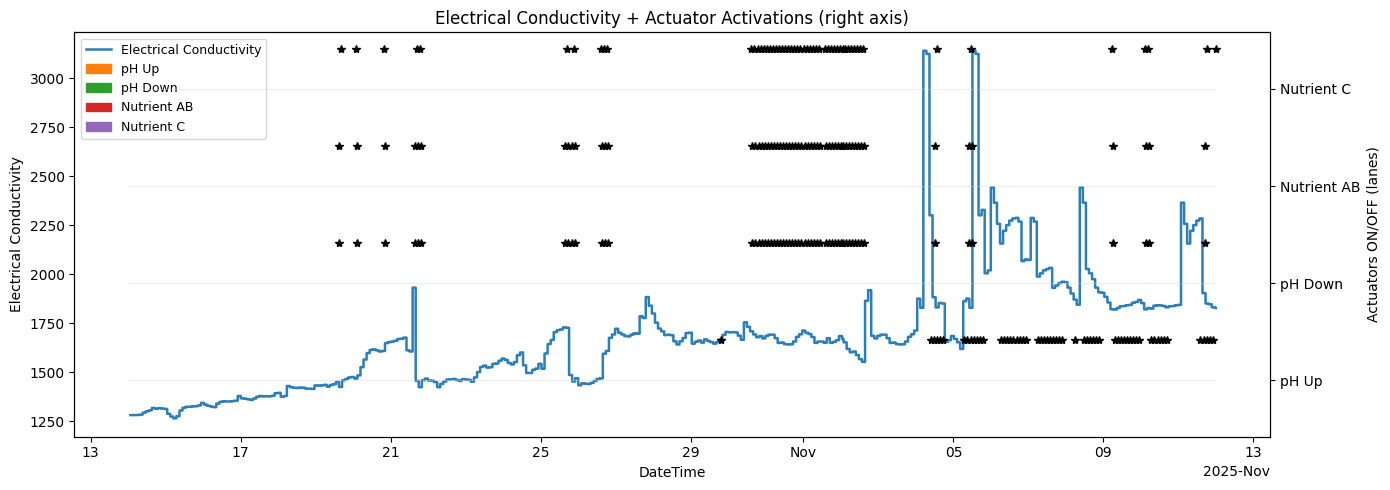

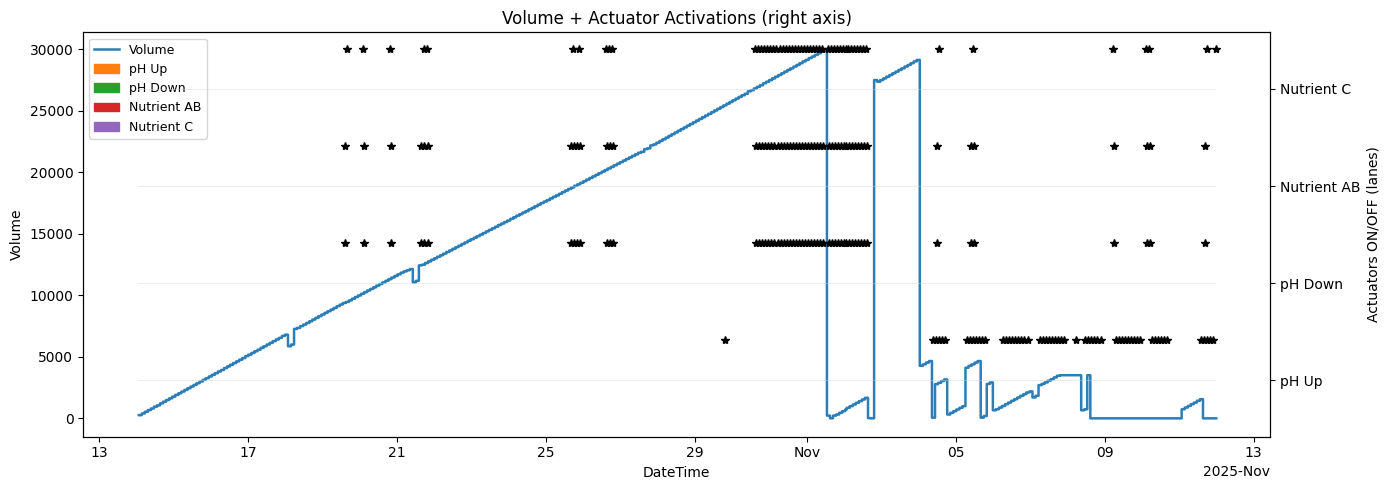

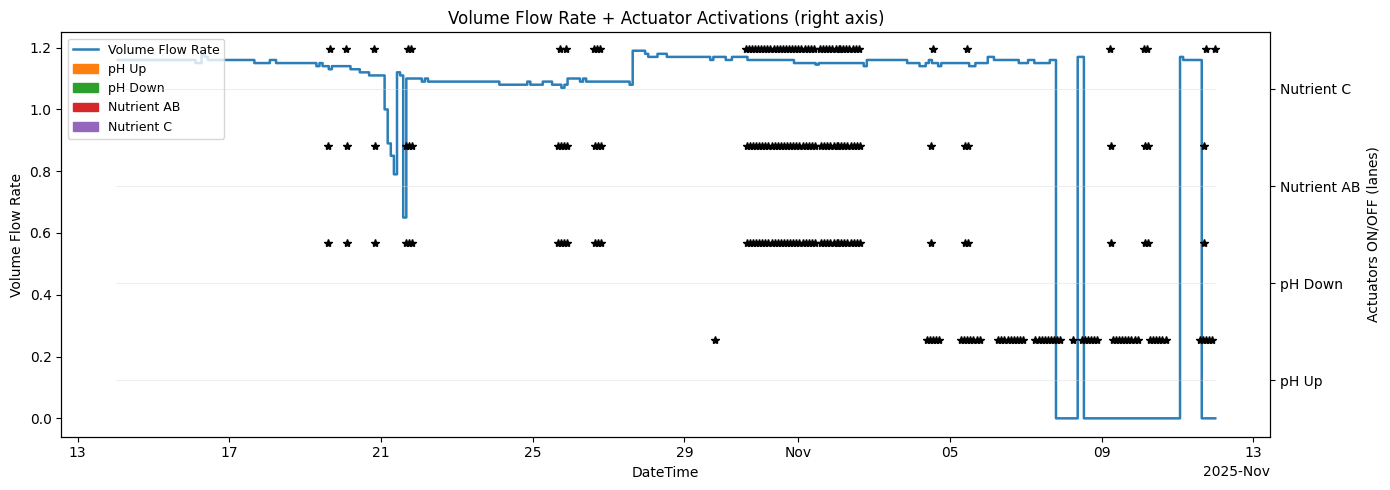

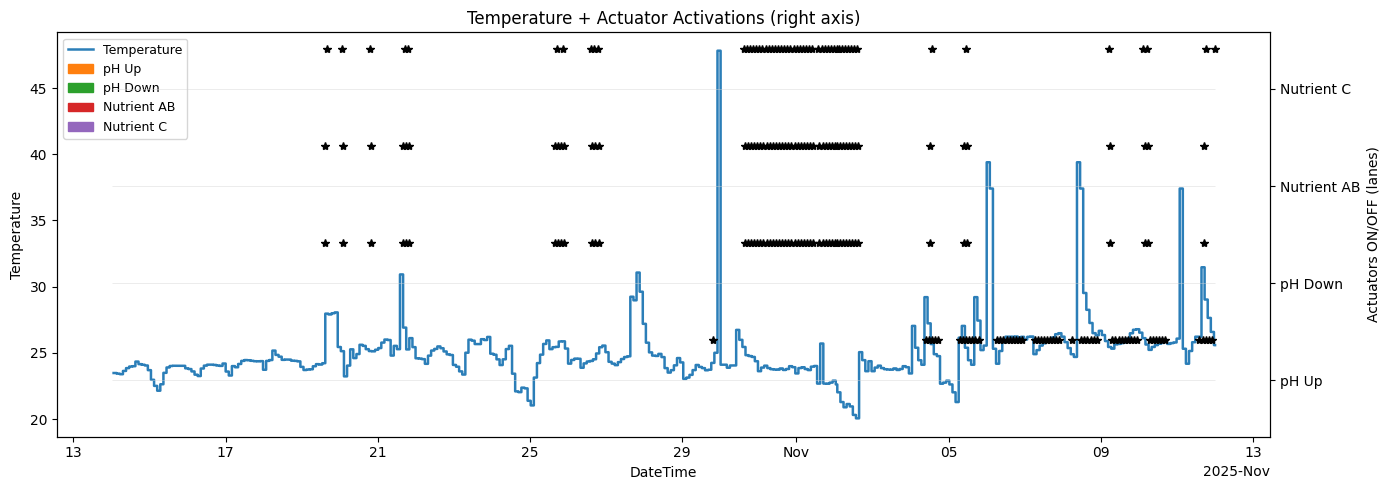

In [10]:
# loop over all nutrient cols and plot with actuators
nutr_cols = ["Electrical Conductivity", "Volume", "Volume Flow Rate", "Temperature"]
nutr_act_cols = ["pH Up Duration", "pH Down Duration", "Nutrient AB Duration", "Nutrient C Duration"]  
for nutr in nutr_cols:
    plot_factor_with_actuators(
        df=merged_nutr_df,
        factor_col=nutr,
        actuator_cols=nutr_act_cols,
        factor_time_col="NutrTime",
        start=None,
        end=None,       
        figsize=(14,5)
    )